In [551]:
import numpy as np
from itertools import combinations
import networkx as nx 


with open("../data/day19.txt", "r") as f:
    input = f.read()

data = [[[int(c) for c in b.split(",")] for b in s.split("\n")[1:]] for s in input.split("\n\n")]

### Puzzle 1

In [480]:
# Image registration (correlation) probably too slow
# r.apply is way too slow (15s), see appendix
# matrix multiplication also too slow (10s)
# Simply loop over translations, axis orientations and signs

def get_transform(M, d):
    return lambda v: v @ M.T + d


def get_inv_transform(M, d):
    return lambda v: (v - d) @ M


def find_transform(data0, data1):
    """Return transformation functions"""
    transform = np.zeros((3, 3), dtype=int)
    d = np.array([0, 0, 0])
    axes = [0, 1, 2]
    for dx in range(-2000, 2001):
        for sign in [1, -1]:
            for axis0 in range(0,3):
                for axis1 in range(0,3): # can be simplified, one less here
                    c0 = data0[:, axis0]
                    c1 = sign * data1[:, axis1] + dx
                    count = len((set(c0).intersection(c1)))
                    if count == 11 or count == 10:
                        print(f"Count of {count} found")
                    if count >= 11: # Supposed to be 12, but doesn't work!
                        transform[axis0, axis1] = sign
                        d[axis0] = dx
                        axes.remove(axis0)
                        if not axes:
                            return get_transform(transform, d), get_inv_transform(transform, d)
    return None


In [ ]:
# Create list of graph edges with transformation functions
# Slow, about 6 mins.
edge_list = []
for s0, s1 in combinations(range(len(data)), r=2):
    data0 = np.array(data[s0])
    data1 = np.array(data[s1])
    functions = find_transform(data0, data1)
    if functions:
        print(f"Mapping found between {s0} and {s1}")
        edge_list.append((s0, s1, {"t": functions[1]}))
        edge_list.append((s1, s0, {"t": functions[0]}))

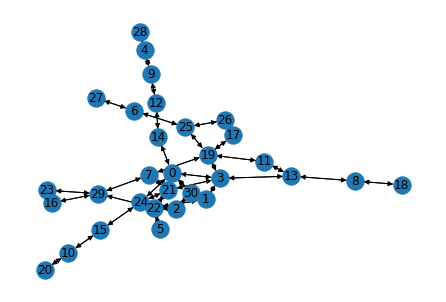

In [552]:
# Create graph from edge list and draw
G = nx.DiGraph()
G.add_edges_from(edge_list)
nx.draw(G, with_labels=True)

In [554]:
# Find shortest path to scanner 0 from every other scanner and transform beacon coordinates
all_beacons = np.array(data[0]) # array to store all beacons relative to scanner 0
loc_dict = {} # dict to store location of scanners relative to scanner 0
for scanner in range(1, len(data)):
    try:
        path = nx.shortest_path(G, scanner, 0)
        dx = np.array([0,0,0])
        beacons = data[scanner]
        for u, v in zip(path[:-1], path[1:]):
            f = G.get_edge_data(u, v)["t"]
            dx = f(dx)
            beacons = f(beacons)
        loc_dict[scanner] = list(dx)
        all_beacons = np.concatenate((all_beacons, beacons))   
    except:
        print(f"No path from {scanner}") 

all_beacons_deduplicated = set([tuple(beacon) for beacon in all_beacons])
print(len(all_beacons_deduplicated))

376


### Puzzle 2
Not beacons, but scanner distance.

In [568]:
def manhattan(pair):
    return np.sum(np.abs(np.array(pair[1]) - np.array(pair[0])))

pairs = combinations(list(loc_dict.values()), r=2)
dist_list = [manhattan(pair) for pair in pairs]
np.sort(dist_list)[-1]

10772

### Appendix

In [ ]:
r, _ = R.align_vectors(data[0][0:2], data[1][0:2])
r.as_rotvec()

array([ 2.67712574, -0.17301807, -0.18620982])

In [ ]:
# Generate euler angles for all 24 orientations
facings = [0, 180]
orientations = [0, 90, 180, 270]

def rotate(l, n):
    return l[-n:] + l[:-n]

angles = []
for axis in range(3):
    for facing in facings:
        for orientation in orientations:
            if axis == 0:
                angles.append([orientation, facing, 0])
            elif axis == 1:
                angles.append([0, orientation, facing + 90])
            elif axis == 2:
                angles.append([0, facing + 90, orientation])
angles


In [ ]:
from scipy.spatial.transform import Rotation as R
# For now only rotations

r = R.from_euler('xyz', angles, degrees=True)

In [ ]:
M = r.as_matrix().astype(int)

In [ ]:
# Matrix multiplication is slow
for dx in range(-2000, 2001):
    for m in M:

        x0 = [tuple(c) for c in data[0]]
        #x1 = [tuple(c) for c in ]

        x1d = [tuple([n - dx for n in c]) for c in data[1] @ m]
        count = len(list(set(x0).intersection(x1d)))

        #print(x1d)
        if count >= 12:
            print(dx)
            print(count)
            print(list(set(x0).intersection(x1d)))
            #break


In [ ]:
# Testing

M = np.array([
    [1, 0, 0],
    [0, 0, -1],
    [0, 1, 0],
])
(M @ np.array(data[0]).T).T
